This notebook implements a basic workflow to train and evaluate a model to classify the IMDB movie reviews. Note that there are many important aspects not covered, see a tentative list of extensions at the end.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score,
    recall_score,
    make_scorer, 
    roc_curve,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os, re

from pathlib import Path
pd.set_option('display.max_colwidth', 200)

## 1. Load and prepare data

Download and extract the data somewhere in your machine

```
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!mv aclImdb_v1.tar.gz some_folder_you_like
!tar -zxf some_folder_you_like/aclImdb_v1.tar.gz -C some_folder_you_like
```

Then add a symlink to connect that folder to `data/external`. For example:

```
ln -s  ~/Documents/Marc/datasets/aclImdb data/external
```

In [2]:
def read_and_dump_pos_neg_texts(data_dir, dump_filename):
    pos_texts, neg_texts = [], []
    for file in data_dir.glob(f"pos/*txt"):
        with open(file, "r") as f:
            pos_texts.append(f.read())
    for file in data_dir.glob(f"neg/*txt"):
        with open(file, "r") as f:
            neg_texts.append(f.read())

    df = pd.DataFrame({"text": pos_texts + neg_texts, "label": 0})
    df.iloc[:len(pos_texts), 1] = 1
    joblib.dump(df, dump_filename)
    return df

In [3]:
PATH_EXTERNAL = Path("../data/external/aclImdb/")
PATH_INTERNAL = Path("../data/interim/")
DIR_TRAIN = PATH_EXTERNAL / "train"
DIR_TEST = PATH_EXTERNAL / "test"
DATA_TRAIN_FILENAME = PATH_INTERNAL / "train.joblib"
DATA_TEST_FILENAME = PATH_INTERNAL / "test.joblib"

if not os.path.exists(DATA_TRAIN_FILENAME):
    df_train = read_and_dump_pos_neg_texts(DIR_TRAIN, DATA_TRAIN_FILENAME)
    df_test = read_and_dump_pos_neg_texts(DIR_TEST, DATA_TEST_FILENAME)
else:
    df_train = joblib.load(DATA_TRAIN_FILENAME)
    df_test = joblib.load(DATA_TEST_FILENAME)

In [4]:
df_train.text[0]

'For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.'

(25000, 2)


,text,label
12858,"Unbelievably bad acting, a no good, unclear story and flashy images and slow-motions where they are needed the least: Adrenaline is everything a movie should not be.<br /><br />Georgina Verbaan (a...",0
15351,"The movie has only one flaw, unfortunately this flaw damages all credibility of the piece.<br /><br />It starts with the condemnation of the Israeli occupation of disputed territories. It fails to...",0
22423,"The 1990's begun to have day time talk shows sprout up left and right. Every network had one, and they all lacked one thing Originality. Ricky Lake was just another show to entertain the obese tra...",0
17365,This is the worst sequel on the face of the world of movies. Once again it doesn't make since. The killer still kills for fun. But this time he is killing people that are making a movie about what...,0
24062,"Tourists head to Ireland for a school trip to learn about Druids. What they encounter is a horrific tale of cannibalistic killers.<br /><br />If I had to sum up Evil Breed, it would be a low grade...",0


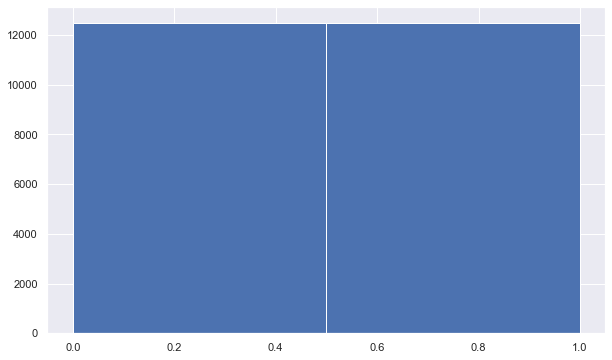

In [5]:
sns.set(rc={'figure.figsize':(10, 6)})
df_train.label.hist(bins=2)
print(df_train.shape)
df_train.sample(5)

We can see that this is a perfectly balanced dataset, as explained in the data description.

## 2. Data representation

We need a translation from raw input (in our case the text for the movie review) to some representation the model can learn from. We'll do this by employing a Bag of Words approach, using a TF-IDF representation.

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=3)

## 3. Model fitting and evaluation

I will use Logistic Regression (LR), as it's proved to give strong baselines. Other ideas are proposed at the end. Given that this is a balanced dataset, I will measure accuracy, true positive rate (TPR), and true negative rate (TNR).

In [7]:
X, y = df_train.text, df_train.label

In [8]:
accuracy = make_scorer(accuracy_score)
tpr = make_scorer(recall_score)

def tnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)
tnr_scorer = make_scorer(tnr)
scoring = {"accuracy": accuracy, "tpr": tpr, "tnr": tnr_scorer}

Let's see how our model performs for a simple pipeline with TF-IDF + LR for 3-fold CV

In [9]:
# without bigrams
tfidf_vectorizer.set_params(ngram_range=(1, 1))
pipeline = Pipeline([
    ("tfidf", tfidf_vectorizer), 
    ("lr", LogisticRegression(class_weight="balanced", solver="lbfgs"))
])
cross_validate(pipeline, X, y, scoring=scoring , cv=KFold(3, shuffle=True, random_state=23), 
               return_train_score=True, n_jobs=3, verbose=True)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.2s finished


{'fit_time': array([10.1649878 , 10.40221405,  9.43907785]),
 'score_time': array([3.71414399, 3.64152408, 4.05339694]),
 'test_accuracy': array([0.88828894, 0.88311532, 0.88059522]),
 'train_accuracy': array([0.93591744, 0.93760125, 0.93772125]),
 'test_tpr': array([0.90026564, 0.89894129, 0.8974542 ]),
 'train_tpr': array([0.94496949, 0.94822627, 0.94612511]),
 'test_tnr': array([0.87646077, 0.86736893, 0.86343826]),
 'train_tnr': array([0.92680872, 0.92694942, 0.92939068])}

In [10]:
# with bigrams
tfidf_vectorizer.set_params(ngram_range=(1, 2))
pipeline = Pipeline([
    ("tfidf", tfidf_vectorizer), 
    ("lr", LogisticRegression(class_weight="balanced", solver="lbfgs"))
])
cross_validate(
    pipeline, X, y, scoring=scoring , cv=KFold(3, shuffle=True, random_state=23), 
    return_train_score=True, n_jobs=3)

{'fit_time': array([37.42815709, 37.98333383, 36.25462484]),
 'score_time': array([5.73623705, 5.44846106, 5.86338019]),
 'test_accuracy': array([0.8899688 , 0.88275531, 0.87951518]),
 'train_accuracy': array([0.949898  , 0.95062099, 0.950201  ]),
 'test_tpr': array([0.90340497, 0.9006256 , 0.8974542 ]),
 'train_tpr': array([0.95705228, 0.95949185, 0.95781608]),
 'test_tnr': array([0.87669926, 0.86497486, 0.86125908]),
 'train_tnr': array([0.94269893, 0.94172774, 0.94265233])}

We can see how bigrams improve a bit the predictive power, at the cost of fit and score time. This would be one of the possible hyper-parameters to optimise. I will stick to just unigrams for simplicity. Besides, it looks like all folds are similar, so from here I will just do train-test and analyse whether we can calibrate a better threshold than the default 0.5.

# Decision Threshold calibration

Here I'm just showing a proof-of-concept about how to do calibration. This can be done better, e.g. nested cross-validation, and there's work right now in sklearn around this, see https://github.com/scikit-learn/scikit-learn/pull/10117.

(actually I already contributed to that PR discussion and planning to contribute with code if this continues being stuck 😊)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.6, test_size=0.4, stratify=y, random_state=23
)
tfidf_vectorizer.set_params(ngram_range=(1, 1))
pipeline = Pipeline([
    ("tfidf", tfidf_vectorizer), 
    ("lr", LogisticRegression(class_weight="balanced", solver="lbfgs"))
])
pipeline.fit(X_train, y_train)
prob_val = pipeline.predict_proba(X_val)

0.5000443203891702 0.1324 0.8676 0.8996 0.8835999999999999
0.5318269547201306 0.1094 0.8906000000000001 0.8778 0.8842000000000001


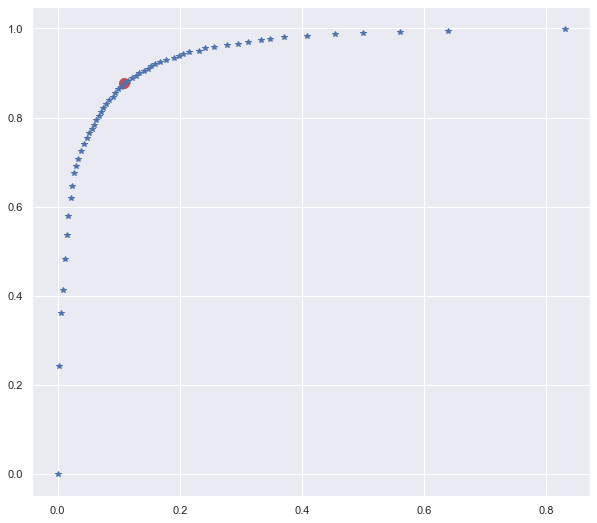

In [12]:
fpr, tpr, thresholds = roc_curve(y_val, prob_val[:, 1])
idx = np.abs(thresholds - 0.5).argmin()
print(thresholds[idx], fpr[idx], 1 - fpr[idx], tpr[idx], (1 - fpr[idx] + tpr[idx]) / 2)
idx = (tpr + 1 - fpr).argmax()
optimal_threshold = thresholds[idx]
print(optimal_threshold, fpr[idx], 1 - fpr[idx], tpr[idx], (1 - fpr[idx] + tpr[idx]) / 2)
plt.figure(figsize=(10, 9))
plt.plot(fpr[::30], tpr[::30], "*")
plt.scatter(fpr[idx], tpr[idx], c="r", s=100)

From the ROC curve and the numbers above we can see that 0.53 seems to be better than 0.5 in terms of accuracy. The difference is not dramatical anyways. Let's use this threshold and check that we get the same numbers.

0.8842


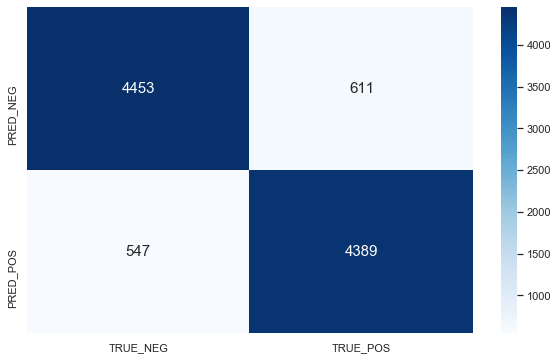

In [13]:
pred_val = (prob_val[:, 1] >= optimal_threshold).astype(int)
cm = confusion_matrix(y_val, pred_val)
print(accuracy_score(y_val, pred_val))
df_cm = pd.DataFrame(
    cm, 
    index = ["TRUE_NEG", "TRUE_POS"], 
    columns = ["PRED_NEG", "PRED_POS"]
)
sns.heatmap(df_cm.T, annot=True, annot_kws={"size": 15}, cmap='Blues', fmt='g')

And now I will use this for the test set:

0.87488
0.87244


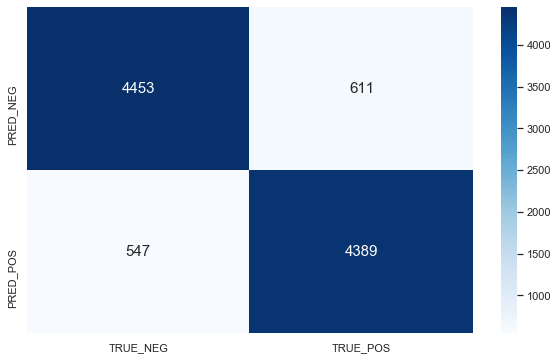

In [14]:
X_test, y_test = df_test.text, df_test.label
prob_test = pipeline.predict_proba(X_test)
pred_test = (prob_test[:, 1] >= 0.5).astype(int)
print(accuracy_score(y_test, pred_test))
pred_test = (prob_test[:, 1] >= optimal_threshold).astype(int)
print(accuracy_score(y_test, pred_test))

cm = confusion_matrix(y_val, pred_val)
df_cm = pd.DataFrame(
    cm, 
    index = ["TRUE_NEG", "TRUE_POS"], 
    columns = ["PRED_NEG", "PRED_POS"]
)
sns.heatmap(df_cm.T, annot=True, annot_kws={"size": 15}, cmap='Blues', fmt='g')

We can see that for this particular test set the original threshold was better indeed. Notice that from here we would NOT change the threshold back to 0.5, as otherwise we would be using the test set to tune our model!

## Further work

Some more ideas or directions to explore for the future (keep in mind that all these assume we use classical NLP, all ideas about a Deep Learning approach will go to the Colab Notebook https://colab.research.google.com/drive/1YUewI5gALb78zVKD0FHtbI7KI3nEwT5y):

- Cleaning data: even though it's usually one of the least promoted parts of ML & NLP, cleaning data might be very useful to help the model stop focusing on noise. For example, in some NLP problems one wants to remove preambles, signatures, distracting single quotes, extra space, contractions, etc. Another example of data cleaning includes lemmatisation, allowing to aggregate important words referring to the same concept altogether. One way to notice about these kind of things is to perform a feature importance analysis after training the model, e.g. by looking at which terms from TF-IDF the model picked as more important.
- Data representation: while we used TF-IDF to represent a text (Bag of words approach), we could use other representations.
- Use the unsupervised data to learn a better vocabulary for the TF-IDF step.
- Use more complex (non-deep-learning-based) models, e.g. SVM, RF, etc.
- Use more feature engineering, e.g.
  - Count entities like names, locations, etc, and use them as extra features. This can potentially use a Named Entity Recognition (NER) system, e.g. the one in [spaCy](spacy.io).
  - Topic features: extract topics to learn more about the dataset / add them as features to improve the classifier. Probably LDA - gensim library - is good enough, but more advanced algos exist like EnsembleLDA.
  - Use word embeddings based features.
  
- Hyper-parameter optimisation (HPO): use e.g. GridSearchCV from sklearn or even Bayesian optimisation, e.g. with [hyperopt](http://hyperopt.github.io/hyperopt/) to optimise the hyper-parameters of the used models, e.g. `C` in Logistic Regression, or the decision threshold.
- Better model evaluation, e.g. 
   - [learning curves](https://scikit-learn.org/stable/modules/learning_curve.html), overfitting vs underfitting analysis, etc.
   - nested cross-validation (NCV). Strictly speaking, in order to perform K-fold and HPO properly, one should perform NCV to avoid data leakage.